## Загрузка данных

Загружаю пакеты

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
import seaborn
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

%matplotlib inline
pd.options.mode.chained_assignment = None

Загружаю данные. Датасет доступен тут: https://www.kaggle.com/sdolezel/black-friday

In [2]:
# Загружаю датасет из своей директории
data = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/BlackFriday.csv", na_values="NaN")

Посмотрю, как выглядят данные:

In [4]:
print(data.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN   

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


## Предобработка

В этом датасете собраны данные о клиентах магазина и их покупки. Поскольку моя задача - кластеризировать клиентов, то часть данных мне не нужна. Я оставлю только данные о клиентах и общую сумму покупок. Сумма покупок будет целевым признаком, на основании которого я хочу получить разные кластеры клиентов. Описание признаков можно посмотреть на kaggle по ссылке выше.

In [5]:
# Удаляю ненужные столбцы
data.drop(['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis = 1, inplace = True)

In [6]:
# Группирую по пользователям сумму покупок и удаляю User_id
col_names = data.iloc[:,:-1].columns.tolist()
data_new = data.groupby(col_names).agg('sum').reset_index()
data_new.drop(columns = 'User_ID', inplace = True)
data_new.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
0,F,0-17,10,A,2,0,333481
1,M,55+,16,C,4+,0,810353
2,M,26-35,15,A,3,0,341635
3,M,46-50,7,B,2,1,205987
4,M,26-35,20,A,1,1,821001


In [120]:
# Чекну на нулевые значения
data_new.isnull().values.any()

False

Мой датасет готов к предобработке. В первую очередь мне нужно избавиться от категориальных переменных, таких как: пол, возраст... К каждому признаку нужен свой подход:

### Пол

Пол закодирован двумя значениями, их можно легко заменить на 0 и 1 без потери информации.

In [9]:
print('Gender:',data_new.Gender.unique())
data_new.Gender.replace(['F', 'M'], [0,1], inplace = True)
print('New Gender:',data_new.Gender.unique())

Gender: ['F' 'M']
New Gender: [0 1]


### Возраст

В возрасте присутствует несколько групп. Поскольку я могу точно определить, какая группа по возрасту старше или младше (больше, меньше), я отсортирую группы повозрастанию и присвою им возрастающий ряд чисел. Так я сохраню информацию о том что группы отличаются + еще на сколько и в какую сторону они отличны.

In [10]:
print('Age:',data_new.Age.unique())
data_new.Age.replace(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'], [1, 2, 3, 4, 5, 6, 7], inplace = True)
print('New Age:',data_new.Age.unique())

Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
New Age: [1 7 3 5 6 4 2]


### Количество прожитых лет в городе

Тут поступаю так же как с возрастом.

In [11]:
print('Stay_In_Current_City_Years:',data_new.Stay_In_Current_City_Years.unique())
data_new.Stay_In_Current_City_Years.replace(['0', '1', '2', '3', '4+'], [1,2,3,4,5], inplace = True)
print('New Stay_In_Current_City_Years:',data_new.Stay_In_Current_City_Years.unique())

Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
New Stay_In_Current_City_Years: [3 5 4 2 1]


### Город

Просто пронумеровать города, как это делал я выше, не получится. Иначе я заложу в них неверную информацию: модель не сможет правильно понять мой посыл. Для нее город под номером один будет 'меньше' города под номером два ровно на 100%, так делать не надо. Лучше под каждый город выделить отдельный признак и кодировать факт этого города как \[0,1\]. Новые переменные называются дамми и для них в пандасе есть отдельный метод)

In [12]:
print('City_Category:',data_new.City_Category.unique())
data_new = data_new.drop(columns = 'City_Category').join(pd.get_dummies(data_new.City_Category))
data_new.head(1)

City_Category: ['A' 'C' 'B']


,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Purchase,A,B,C
0,0,1,10,3,0,333481,1,0,0


### Сумма покупок

Сумма покупок - вещественный признак. И к нему нужен будет отдельный подход.
Поскольку я решил кластеризировать клиентов, то хорошо бы понять а на какие группы я их хочу кластеризировать? У меня есть непрерывный ряд от минимального до максимального значения. Кстати, посмотрю на него:

In [125]:
data_new.Purchase.describe()

count    5.891000e+03
mean     8.517515e+05
std      9.329978e+05
min      4.410800e+04
25%      2.349140e+05
50%      5.126120e+05
75%      1.099005e+06
max      1.053678e+07
Name: Purchase, dtype: float64

Ну вот, есть средняя, медиана, квантили...Замечу, что минимальная сумма от максимальной отличается на три порядка. Этим можно воспользоваться и сгруппировать клиенов по количеству порядков, получив тем самым 3 группы. Но если клиентов с максимальным порядком всего пату человек, то ничего хорошего из такой группировки не выйдет.

Поэтому я просто разделю наш ряд на 5 равных частей и это будет 5 групп пользователей с определенными диапазонами суммы покупок:

In [13]:
step = round((data_new.Purchase.max() - data_new.Purchase.min()) / 5).astype('int')
for i in range(data_new.Purchase.min(), data_new.Purchase.max(), step): print(i)

44108
2142643
4241178
6339713
8438248


In [14]:
data_new['Cat_Purchase'] = 0
data_new['Cat_Purchase'][data_new.Purchase < 2142643] = 1
data_new['Cat_Purchase'][(data_new.Purchase >= 2142643) & (data_new.Purchase < 4241178)] = 2
data_new['Cat_Purchase'][(data_new.Purchase >= 4241178) & (data_new.Purchase < 6339713)] = 3
data_new['Cat_Purchase'][(data_new.Purchase >= 6339713) & (data_new.Purchase < 8438248)] = 4
data_new['Cat_Purchase'][data_new.Purchase >= 8438248] = 5
print('Cat_Purchase:',data_new.Cat_Purchase.unique())

data_new.drop(columns = 'Purchase', inplace = True)

Cat_Purchase: [1 2 3 4 5]


In [15]:
data_new.head()

,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,A,B,C,Cat_Purchase
0,0,1,10,3,0,1,0,0,1
1,1,7,16,5,0,0,0,1,1
2,1,3,15,4,0,1,0,0,1
3,1,5,7,3,1,0,1,0,1
4,1,3,20,2,1,1,0,0,1


## Визуализация

На данном этапе должен быть расшиернный разведывательный анализ по каждому признаку. Но для моих целей можно ограничиться гистограммами:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000137ADD97D68>,
      dtype=object)

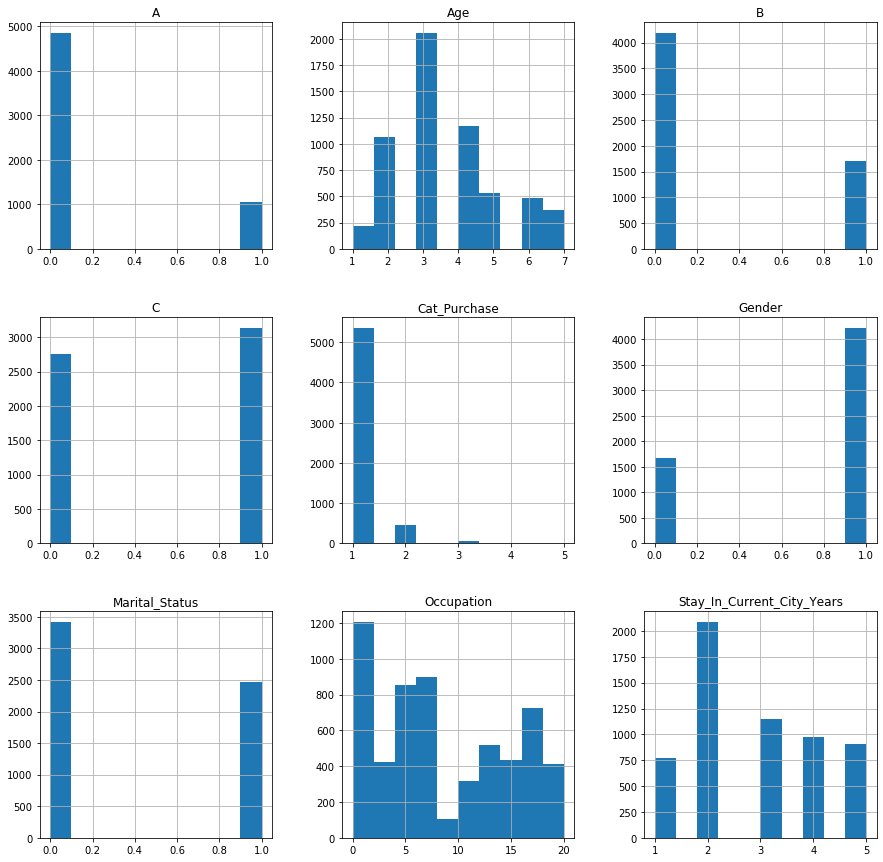

In [18]:
data_new.hist(figsize = (15,15))

Признаки мы уже изучили, когда их кодировали. Сейчас основная задача - оценить распределения признаков. Видно, что честь признаков бинарна и несбалансированна, у не бинарных есть не нормальные распределения. Это приводит меня к тому, что использовать алгоритмы на основе евклидова расстояния - не лучшая идея. Пойду другим путем.

## Кластеризация

Я воспользуюсь двумя алгоритмами кластеризации и визуализации данных
1. t-SNE - алгоритм нелинейного снижения размерности
2. MDS - многомерное шкалирование

### TSNE

Особенность этого алгоритма в том, что в качестве меры близости объектов он использует не евклидово расстояние, а дивергенцию Кульбака-Лейблера (мера удаленности друг от друга вероятностных распределений объектов).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

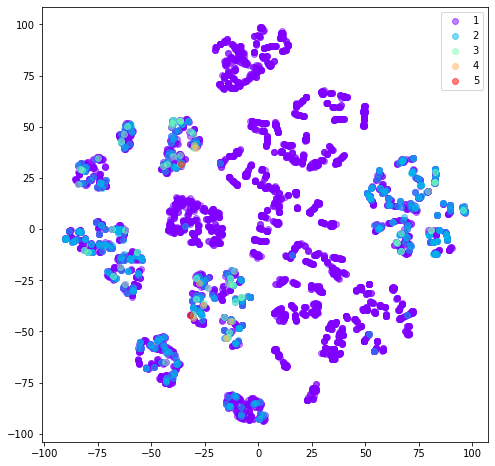

In [171]:
sdata = shuffle(data_new, random_state=321)
data_subset = scale(sdata.drop(columns= 'Cat_Purchase'))
response_subset = sdata["Cat_Purchase"]

tsne = TSNE(random_state = 321, metric = 'cosine')
tsne_representation = tsne.fit_transform(data_subset)

colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
plt.figure(figsize=(8,8))
for y, c in zip(set(data_new.Cat_Purchase), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0], 
                tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()
plt.show()

Напомню, что меня интересует, можно ли выделить (кластеризировать) клиентов с разными суммами покупок. На графике видно, что алгоритм неплохо справляется с этой задачей: есть отдельные кластеры с группой 1 (это самые низкие чеки) и так же кластеры, куда попадает много высоких чеков.

### MDS

Идея метода в том, что попарные расстояния между объектами в новом признаковом пространстве должны быть, как можно ближе к исходным расстояниям. Т.е. если расстояние между объектами в исходном пространстве равно 10, то в новом пространстве алгоритм пытается разместить объекты как можно ближе к 10. И так много раз, пока пространство не схлопнется в трех- или двумерное:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

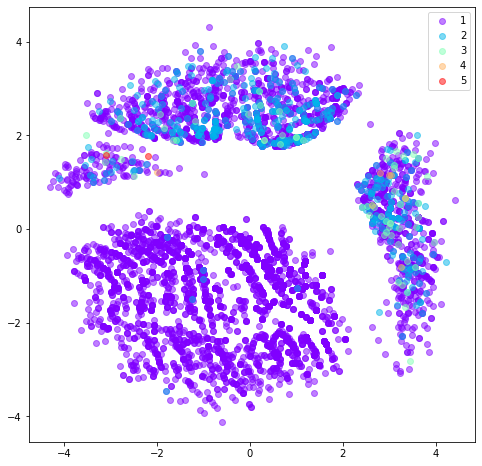

In [168]:
mds = MDS( random_state = 321)
MDS_transformed = mds.fit_transform(data_subset)

colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
plt.figure(figsize=(8,8))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed[response_subset.values==y, 0], 
                MDS_transformed[response_subset.values==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()

Ну так себе. И еще разок MDS, только с косинусной метрикой расстояния:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

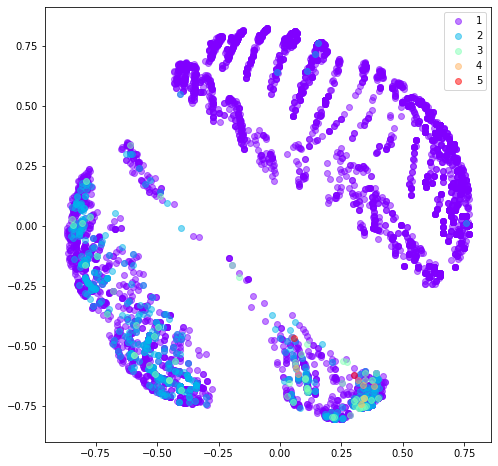

In [175]:
mds = MDS( random_state = 321, dissimilarity="precomputed")
MDS_transformed_cos = mds.fit_transform(pairwise_distances(data_subset, metric = 'cosine'))

colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
plt.figure(figsize=(8,8))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed_cos[response_subset.values==y, 0], 
                MDS_transformed_cos[response_subset.values==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()

MDS тоже неплохо справился с задачей, визуально можно определить в каких кластерах плотность высоких чеков выше

## Итоги

На примере данных магазина, я показал, как можно кластеризировать базу клиентов по целевому признаку и визуализировать результат. 

Алгоритмов кластеризации - много. Я показал только два, не самых простых, но интересных. Из специфичность в том, что основаны они на не линейном преборазовании, а значи, улавливают нелинейные взаимосвязи объектов.

Такую процедуру кластеризации полезно проводить, как разведку перед построением прогнозной модели. Если визуально в кластерах находятся разные целевые группы, то значит есть смысл пытаться строить предсказательную модель, если же распределение целевых групп в каждом кластере одинаково, то либо алгоритм не справляется, либо задача не решаема.